<div align="center">
    
<br>

# FINE-GRAINED EMOTIONAL CONTROL OF TEXT-TO-SPEECH 

### LEARNING TO RANK INTER- AND INTRA-CLASS EMOTION INTENSITIES

Shijun Wang, Jón Guðnason, Damian Borth

**ICASSP 2023**

<br>

---

<br>

</div>

In [22]:
##############################################
# 1. Paths
##############################################
DATA_PATH           = '/workspace/data/EmoV-DB'
CORPUS_PATH         = '/workspace/montreal_forced_aligner/corpus'
TEXTGRID_PATH       = '/workspace/montreal_forced_aligner/aligned'
PREPROCESSED_PATH   = '/workspace/preprocessed'
EXPERIMENT_PATH     = '/workspace/experiments'


##############################################
# 2. Preprocessing
##############################################
NOISE_SYMBOL        = ' [noise] '
SPEAKERS            = ['bea', 'jenie', 'josh', 'sam']
EMOTIONS            = ['neutral', 'amused', 'angry', 'disgusted', 'sleepy']
SIL_PHONES          = ['sil', 'spn', 'sp', '']
PITCH_AVERAGING     = False
ENERGY_AVERAGING    = False
MATCH_TRANSCRIPT    = False


##############################################
# 3. Audio (optimized for vocoder)
##############################################
SAMPLING_RATE       = 16000
HOP_LENGTH          = 256
WIN_LENGTH          = 1024
N_FFT               = 1024
N_MELS              = 80
F_MIN               = 0.0
F_MAX               = 8000.0


##############################################
# 4. Training
##############################################
N_EPOCHS            = 100
MAX_ITERATIONS      = 50000
BATCH_SIZE          = 32
LEARNING_RATE       = 0.000001


##############################################
# 5. Model
##############################################
N_ENCODER_LAYERS    = 4
N_HEADS             = 2
HIDDEN_DIM          = 256
KERNEL_SIZE         = 9
DROPOUT             = 0.1
ALPHA               = 0.1
BETA                = 1.0


##############################################
# 6. Miscellaneous
##############################################
MARKER              = ['o', '^', 's', 'd']

In [23]:
import os
import tgt
import glob
import tqdm
import json
import torch
import scipy
import random
import librosa
import sklearn
import numpy as np
import pyworld as pw
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from text import _clean_text
from pathlib import Path
from IPython.display import Audio
from torch.utils.tensorboard import SummaryWriter
from sklearn.preprocessing import StandardScaler
from speechbrain.lobes.models.FastSpeech2 import mel_spectogram

#### **1. Preprocessing**



In [3]:
audio_id_to_transcript = {}

with open(os.path.join(DATA_PATH, 'cmuarctic.data')) as f:
    for line in f.readlines():
        audio_id, transcript = line[2:-2].split('\"')[:2]

        audio_id = audio_id.strip()
        transcript = transcript.strip()

        if audio_id.startswith('arctic_b'):
            continue
        
        audio_id = audio_id[-4:]
        transcript = NOISE_SYMBOL + _clean_text(transcript, ['english_cleaners']) + NOISE_SYMBOL

        audio_id_to_transcript[audio_id] = transcript.strip()

In [4]:
def prepare_mfa():
    for speaker in tqdm.tqdm(SPEAKERS):
        for emotion in EMOTIONS:

            # check the path existence: josh has only three emotions
            spk_emo_path = os.path.join(DATA_PATH, speaker, emotion)
            if not os.path.exists(spk_emo_path):
                continue
            
            # resample and create .lab file
            for wav_path in glob.glob(os.path.join(spk_emo_path, '*.wav')):

                y, sr = librosa.load(wav_path, sr=SAMPLING_RATE)

                audio_id = os.path.basename(wav_path)[:-4]
                transcript = audio_id_to_transcript[audio_id]

                os.makedirs(os.path.join(CORPUS_PATH, speaker), exist_ok=True)

                tgt_path = os.path.join(CORPUS_PATH, speaker, f'{emotion}_{audio_id}')
                scipy.io.wavfile.write(tgt_path + '.wav', sr, y)

                with open(tgt_path + '.lab', 'w') as f:
                    f.write(transcript + '\n')


if os.path.exists(CORPUS_PATH):
    print('Corpus path already exists, skipping preparation.')
else:
    print('Preparing corpus for Montreal Forced Aligner...')
    prepare_mfa()
    print('Corpus preparation completed.')


Corpus path already exists, skipping preparation.


In [ ]:
# download speech dictionary
wget -O /workspace/montreal_forced_aligner/librispeech-lexicon.txt https://openslr.trmal.net/resources/11/librispeech-lexicon.txt 

# prepare environment for montreal forced aligner
conda create -n aligner -c conda-forge montreal-forced-aligner -y

# **important** please make sure to select `aligner` environment
mfa model download acoustic english_us_arpa
mfa validate /workspace/montreal_forced_aligner/corpus /workspace/montreal_forced_aligner/librispeech-lexicon.txt english_us_arpa
mfa align /workspace/montreal_forced_aligner/corpus /workspace/montreal_forced_aligner/librispeech-lexicon.txt english_us_arpa /workspace/montreal_forced_aligner/aligned

In [5]:
def process_textgrid(textgrid_file):

    # read the TextGrid file and extract phone intervals
    tg = tgt.io.read_textgrid(textgrid_file, include_empty_intervals=True)
    tier = tg.get_tier_by_name('phones')
    intervals = [(iv.start_time, iv.end_time, iv.text or '') for iv in tier._objects]

    # filter out empty intervals and silence phones
    starts = np.array([s for s, e, p in intervals])
    ends = np.array([e for s, e, p in intervals])
    start_frames = np.round(starts * SAMPLING_RATE / HOP_LENGTH).astype(int)
    end_frames = np.round(ends * SAMPLING_RATE / HOP_LENGTH).astype(int)
    durations = end_frames - start_frames

    # filter out intervals with zero duration or silence phones
    labels = [p if p not in SIL_PHONES else 'spn' for s, e, p in intervals]
    is_voiced = np.array([p not in SIL_PHONES for s, e, p in intervals])
    if not is_voiced.any():
        print(f'No voiced phones found in {textgrid_file}')
        return [], np.array([], int), 0.0, 0.0

    # filter out intervals with zero duration
    first, last = np.where(is_voiced)[0][[0, -1]]
    phones = labels[first:last + 1]
    durations = durations[first:last + 1]
    speech_start = intervals[first][0]
    speech_end = intervals[last][1]

    return phones, durations, speech_start, speech_end


def trim_audio(y, start_time, end_time):
    s = int(np.round(start_time * SAMPLING_RATE))
    e = int(np.round(end_time * SAMPLING_RATE))
    return y[s:e].astype(np.float32)


def get_pitch(y):
    frame_period = HOP_LENGTH / SAMPLING_RATE * 1000  # in milliseconds
    y = y.astype(np.float64)
    f0, t = pw.dio(y, SAMPLING_RATE, frame_period=frame_period)
    return pw.stonemask(y, f0, t, SAMPLING_RATE)


def get_mel(y):
    y = torch.FloatTensor(y)
    mel, energy = mel_spectogram(
        audio=y,
        sample_rate=SAMPLING_RATE,
        hop_length=HOP_LENGTH,
        win_length=WIN_LENGTH,
        n_mels=N_MELS,
        n_fft=N_FFT,
        f_min=F_MIN,
        f_max=F_MAX,
        power=1,
        normalized=False,
        min_max_energy_norm=True,
        norm="slaney",
        mel_scale="slaney",
        compression=True
    )
    return mel, energy


def expand(values, durations):
    return np.repeat(values, durations)

In [6]:
def remove_outliers(x):
    q1, q3 = np.percentile(x, [25, 75])
    iqr = q3 - q1
    mask = (x >= (q1 - 1.5 * iqr)) & (x <= (q3 + 1.5 * iqr))
    return x[mask]


def normalize_field(speaker, emotion, field, mean, std):
    paths = glob.glob(os.path.join(PREPROCESSED_PATH, speaker, f'{emotion}_*.npz'))
    global_min, global_max = np.inf, -np.inf

    for fp in paths:
        arr = dict(np.load(fp))
        arr[field] = (arr[field] - mean) / std
        np.savez(fp, **arr)
        global_min = min(global_min, arr[field].min())
        global_max = max(global_max, arr[field].max())

    return float(global_min), float(global_max)


def feature_extraction(speaker, emotion, tbar):

    pitch_scaler = StandardScaler()
    energy_scaler = StandardScaler()
    
    wav_paths = glob.glob(os.path.join(CORPUS_PATH, speaker, f'{emotion}_*.wav'))
    for audio_path in wav_paths:

        tbar.update(1)

        audio_id = Path(audio_path).stem.split('_')[-1]
        textgrid_path = os.path.join(TEXTGRID_PATH, speaker, f'{emotion}_{audio_id}.TextGrid')
        transcript_path = Path(os.path.join(CORPUS_PATH, speaker, f'{emotion}_{audio_id}.lab'))

        # check the path existence
        if not Path(textgrid_path).exists():
            continue

        phones, durations, start_t, end_t = process_textgrid(textgrid_path)

        if start_t >= end_t:
            print(f"Invalid start/end: {audio_path}")
            continue

        # trim audio
        y, sr = librosa.load(audio_path, sr=SAMPLING_RATE)
        y = trim_audio(y, start_t, end_t)

        # transcript
        transcript = transcript_path.read_text().strip().replace(NOISE_SYMBOL, '')

        # 1. pitch
        pitch = get_pitch(y)
        if np.count_nonzero(pitch) <= 1:
            print(f"Invalid pitch: {audio_path}")
            continue
        pitch = pitch[:sum(durations)]
        
        # 2. melspectrogram, energy
        mel, energy = get_mel(y)
        mel, energy = mel.numpy(), energy.numpy()
        mel = mel[:, :sum(durations)]
        energy = energy[:sum(durations)]

        if PITCH_AVERAGING:
            pitch = _average_by_duration(pitch, durations)
            pitch = expand(pitch, durations)

        if ENERGY_AVERAGING:
            energy = _average_by_duration(energy, durations)
            energy = expand(energy, durations)

        pitch_clean = remove_outliers(pitch)
        energy_clean = remove_outliers(energy)
        pitch_scaler.partial_fit(pitch_clean.reshape((-1, 1)))
        energy_scaler.partial_fit(energy_clean.reshape((-1, 1)))

        assert len(mel[0]) == len(pitch) == len(energy)
        np.savez(
            os.path.join(PREPROCESSED_PATH, speaker, f'{emotion}_{audio_id}.npz'),
            
            # metadata
            phones=phones,
            emotion=emotion,
            speaker=speaker,
            audio_id=audio_id,
            audio_path=audio_path,
            transcript=transcript,
            textgrid_path=textgrid_path,
            
            # inputs
            mel=mel,
            pitch=pitch,
            energy=energy,
            durations=durations,
        )

    # calculate the normalization parameters
    p_mean, p_std = pitch_scaler.mean_[0], pitch_scaler.scale_[0]
    e_mean, e_std = energy_scaler.mean_[0], energy_scaler.scale_[0]

    # normalize the fields and save the stats
    p_min, p_max = normalize_field(speaker, emotion, 'pitch', p_mean, p_std)
    e_min, e_max = normalize_field(speaker, emotion, 'energy', e_mean, e_std)

    # save the stats
    stats_file = Path(PREPROCESSED_PATH, 'stats.json')
    stats = json.loads(stats_file.read_text()) if stats_file.exists() else {}
    stats.setdefault(speaker, {})[emotion] = {
        'pitch': [p_min, p_max, p_mean, p_std],
        'energy': [e_min, e_max, e_mean, e_std],
    }
    stats_file.write_text(json.dumps(stats, indent=4))
    

def _average_by_duration(values, durations):
    out = np.zeros(len(durations), dtype=np.float32)
    idx = 0
    for i, d in enumerate(durations):
        if d > 0:
            out[i] = values[idx:idx + d].mean()
        idx += max(d, 0)
    return out

In [ ]:
total_wavs = len(glob.glob(os.path.join(CORPUS_PATH, '*', '*.wav')))
tbar = tqdm.notebook.tqdm(total=total_wavs, desc='Processing EmoV-DB')
tbar.n = 0

for speaker in SPEAKERS:
    for emotion in EMOTIONS:

        # check the path existence
        if not os.path.exists(os.path.join(DATA_PATH, speaker, emotion)):
            continue

        # preprocessed path
        os.makedirs(os.path.join(PREPROCESSED_PATH, speaker), exist_ok=True)

        # mel, energy, pitch, durations
        feature_extraction(speaker, emotion, tbar)

processed_wavs = len(glob.glob(os.path.join(PREPROCESSED_PATH, '*', '*.npz')))
print(f'Processed {processed_wavs} audio files out of {total_wavs}.')
tbar.close()

In [7]:
# make train dataset list and test dataset list
train_list = []
test_list = []

for speaker in SPEAKERS:

    # neutral audio ids per speaker
    neu_paths = glob.glob(os.path.join(PREPROCESSED_PATH, speaker, f'neutral_*.npz'))
    neu_ids = [os.path.basename(neu_path)[:-4].split('_')[-1] for neu_path in neu_paths]
    neu_ids = sorted(neu_ids)

    for emotion in EMOTIONS:

        if emotion == 'neutral':
            continue

        emo_paths = glob.glob(os.path.join(PREPROCESSED_PATH, speaker, f'{emotion}_*.npz'))
        emo_ids = [os.path.basename(emo_path)[:-4].split('_')[-1] for emo_path in emo_paths]
        emo_ids = sorted(emo_ids)

        # find common audio ids
        if MATCH_TRANSCRIPT:
            neu_ids = set(neu_ids)
            emo_ids = set(emo_ids)
            audio_ids = sorted(list(neu_ids.intersection(emo_ids)))

            # train
            for audio_id in audio_ids[:-5]:
                train_list.append('|'.join([speaker, emotion, audio_id, audio_id]))

            # test
            for audio_id in audio_ids[-5:]:
                test_list.append('|'.join([speaker, emotion, audio_id, audio_id]))

        else:

            # train
            for emo_audio_id in emo_ids[:-5]:
                for neu_audio_id in random.sample(neu_ids, k=10):
                    train_list.append('|'.join([speaker, emotion, emo_audio_id, neu_audio_id]))

            # test
            for emo_audio_id in emo_ids[-5:]:
                for neu_audio_id in random.sample(neu_ids, k=10):
                    test_list.append('|'.join([speaker, emotion, emo_audio_id, neu_audio_id]))



with open(os.path.join(PREPROCESSED_PATH, 'train.txt'), 'w') as f:
    f.write('\n'.join(train_list) + '\n')
with open(os.path.join(PREPROCESSED_PATH, 'test.txt'), 'w') as f:
    f.write('\n'.join(test_list) + '\n')

#### **2. Utility**

In [8]:
# plot only one melspectrogram
def plot_melspectrogram(mel, save_path=None):

    fig, ax = plt.subplots(figsize=(10, 4))
    im = ax.imshow(mel, aspect='auto', origin='lower', interpolation='none', cmap='viridis')
    ax.set_xlabel('Time (frames)')
    ax.set_ylabel('Mel bands')
    ax.set_title('Melspectrogram')

    cbar = fig.colorbar(im, ax=ax, format='%+2.0f dB')
    cbar.set_label('Amplitude (dB)')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    else:
        plt.show()
    

# plot melspectrograms for GT and predicted
def plot_melspectrograms(mel_gt, mel_pred, save_path=None):
    fig, axes = plt.subplots(2, 1, figsize=(10, 5))
    axes[0].imshow(mel_gt, aspect='auto', origin='lower', interpolation='none', cmap='viridis')
    axes[0].set_title('Ground Truth Melspectrogram')
    axes[0].set_xlabel('Time (frames)')
    axes[0].set_ylabel('Mel bands')

    axes[1].imshow(mel_pred, aspect='auto', origin='lower', interpolation='none', cmap='viridis')
    axes[1].set_title('Predicted Melspectrogram')
    axes[1].set_xlabel('Time (frames)')
    axes[1].set_ylabel('Mel bands')

    cbar = fig.colorbar(axes[0].images[0], ax=axes, format='%+2.0f dB')
    cbar.set_label('Amplitude (dB)')

    fig.subplots_adjust(hspace=0.6, right=0.75)
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    else:
        plt.show()

# plot all features: mel, pitch, energy
def plot_features(mel, ex_pitch, ex_energy, stat, save_path=None):

    pitch_min, pitch_max, pitch_mean, pitch_std = stat['pitch']
    energy_min, energy_max, energy_mean, energy_std = stat['energy']
    
    pitch_min = pitch_min * pitch_std + pitch_mean
    pitch_max = pitch_max * pitch_std + pitch_mean

    ex_pitch = ex_pitch * pitch_std + pitch_mean

    @staticmethod
    def add_axis(fig, ax):
        ax1 = fig.add_axes(ax.get_position(), anchor='W')
        ax1.set_facecolor('none')
        return ax1

    
    fig, ax = plt.subplots(figsize=(10, 3))
    im = ax.imshow(mel, aspect='auto', origin='lower', interpolation='none', cmap='viridis')
    ax.set_anchor('W')
    ax.tick_params(labelsize='x-small', left=False, labelleft=False, right=False, labelright=False)
    ax.set_xlabel('Time (frames)')
    ax.set_title('Melspectrogram')

    ax1 = add_axis(fig, ax)
    ax1.set_xlim(0, mel.shape[1])
    ax1.plot(ex_pitch, color='tomato', label='Pitch', linewidth=2)
    ax1.set_ylim(pitch_min, pitch_max)
    ax1.set_ylabel('Pitch (Hz)', color='tomato')
    ax1.tick_params(labelsize='x-small', colors='tomato', bottom=False, labelbottom=False)
    
    ax2 = add_axis(fig, ax)
    ax2.set_xlim(0, mel.shape[1])
    ax2.plot(ex_energy, color='darkviolet', label='Energy', linewidth=2)
    ax2.set_ylim(energy_min, energy_max)
    ax2.set_ylabel('Energy (dB)', color='darkviolet')
    ax2.yaxis.set_label_position("right")
    ax2.tick_params(labelsize='x-small', colors='darkviolet', bottom=False, labelbottom=False, 
                    left=False, labelleft=False, right=True, labelright=True)

    # plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    else:
        plt.show()

In [24]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def increment_path(base_path):
     
    exp_num = 1
    while True:
        path = os.path.join(base_path, f'exp_{exp_num}')
        if not os.path.exists(path):
            os.makedirs(path)
            return path
        exp_num += 1
    

#### **3. Dataset**

Dataset size: 52440
Batch size: 4
Speakers: tensor([3, 0, 2, 0])
Emotions: tensor([3, 1, 1, 1])
Lengths: tensor([115, 201, 106, 171])


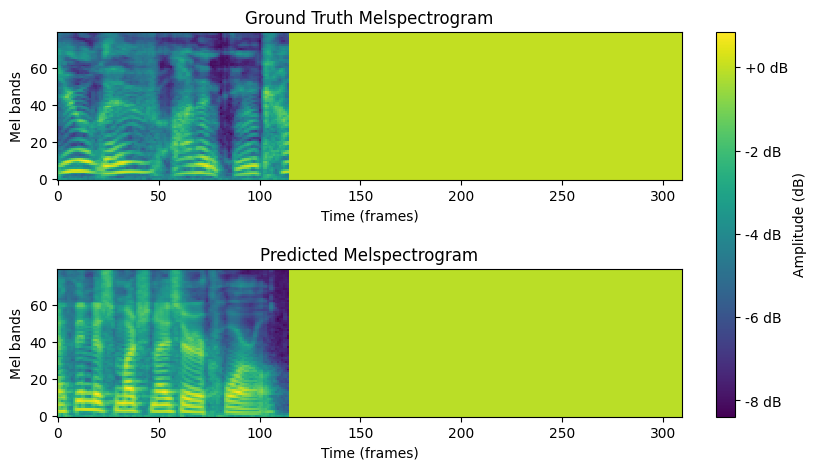

In [10]:
class FineGrainedDataset(torch.utils.data.Dataset):

    def __init__(self, preprocessed_path, split='train'):
        self.split = split
        self.preprocessed_path = preprocessed_path

        self.emo_audio_id = []
        self.neu_audio_id = []
        self.speaker = []
        self.emotion = []

        with open(os.path.join(preprocessed_path, f'{split}.txt'), 'r') as f:
            for line in f.readlines():
                speaker, emotion, emo_audio_id, neu_audio_id = line.strip().split('|')
                self.emo_audio_id.append(emo_audio_id)
                self.neu_audio_id.append(neu_audio_id)
                self.speaker.append(speaker)
                self.emotion.append(emotion)

    def __len__(self):
        return len(self.emo_audio_id)
    
    def __getitem__(self, idx):
        emo_audio_id = self.emo_audio_id[idx]
        neu_audio_id = self.neu_audio_id[idx]
        speaker = self.speaker[idx]
        emotion = self.emotion[idx]

        # load preprocessed data
        speaker_base_path = os.path.join(self.preprocessed_path, speaker)
        emo_data = dict(np.load(os.path.join(speaker_base_path, f'{emotion}_{emo_audio_id}.npz')))
        neu_data = dict(np.load(os.path.join(speaker_base_path, f'neutral_{neu_audio_id}.npz')))

        # prepare inputs
        emo_X = self._prepare_X(emo_data)
        neu_X = self._prepare_X(neu_data)

        return {
            'emo_X': emo_X,
            'neu_X': neu_X,
            'speaker': speaker,
            'emotion': emotion,
        }
    
    def _prepare_X(self, data):
        mel             = data['mel']
        pitch           = data['pitch']
        energy          = data['energy']
        durations       = data['durations']
        phones          = data['phones']
        transcript      = data['transcript']
        audio_path      = data['audio_path']
        textgrid_path   = data['textgrid_path']


        X = np.concatenate([mel, pitch.reshape((1, -1)), energy.reshape((1, -1))], axis=0)
        return X
    

def collate_fn(batch):

    B = len(batch)
    max_T = max([item['emo_X'].shape[1] for item in batch] \
                + [item['neu_X'].shape[1] for item in batch])


    # create a tensor to hold the mel spectrograms
    length = torch.LongTensor(B)
    emo_X = np.zeros((B, N_MELS + 2, max_T), dtype=np.float32)  # +2 for pitch and energy
    neu_X = np.zeros((B, N_MELS + 2, max_T), dtype=np.float32)  # +2 for pitch and energy
    speakers = torch.LongTensor([SPEAKERS.index(item['speaker']) for item in batch])
    emotions = torch.LongTensor([EMOTIONS.index(item['emotion']) for item in batch])


    # pad the mel spectrograms to the same length
    for idx in range(B):

        _emo_X = batch[idx]['emo_X']
        _neu_X = batch[idx]['neu_X']
        T = min(_emo_X.shape[1], _neu_X.shape[1])

        # truncate to the minimum length
        _emo_X = _emo_X[:, :T]
        _neu_X = _neu_X[:, :T]

        # pad the mel spectrograms to the maximum length
        pad_width = max_T - T
        emo_X[idx] = np.pad(_emo_X, ((0, 0), (0, pad_width)), mode='constant', constant_values=0)
        neu_X[idx] = np.pad(_neu_X, ((0, 0), (0, pad_width)), mode='constant', constant_values=0)
        length[idx] = T

    # convert to tensors
    emo_X = torch.FloatTensor(emo_X)
    neu_X = torch.FloatTensor(neu_X)

    return {
        'emo_X': emo_X,
        'neu_X': neu_X,
        'speakers': speakers,
        'emotions': emotions,
        'length': length,
    }


if __name__ == '__main__':
    dataset = FineGrainedDataset(PREPROCESSED_PATH, split='train')
    print(f"Dataset size: {len(dataset)}")

    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=4,
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=0,
    )

    for batch in dataloader:
        emo_X = batch['emo_X']
        neu_X = batch['neu_X']
        speakers = batch['speakers']
        emotions = batch['emotions']
        length = batch['length']

        print(f"Batch size: {len(emo_X)}")
        print(f"Speakers: {speakers}")
        print(f"Emotions: {emotions}")
        print(f"Lengths: {length}")

        plot_melspectrograms(emo_X[0][:N_MELS, :], neu_X[0][:N_MELS, :], save_path=None)

        break


#### **4. Model**

In [25]:
########################################################################
# Transformer Encoder Layer with Convolutional Feed-Forward Network
########################################################################
class ConvTransformerEncoderLayer(nn.Module):

    def __init__(self):
        super(ConvTransformerEncoderLayer, self).__init__()

        # multi-head attention
        self.self_attn = nn.MultiheadAttention(embed_dim=HIDDEN_DIM, num_heads=N_HEADS, dropout=DROPOUT, batch_first=True)

        # convolutional feed-forward network
        self.conv1 = nn.Conv1d(HIDDEN_DIM, HIDDEN_DIM * 4, kernel_size=KERNEL_SIZE, padding=KERNEL_SIZE // 2)
        self.conv2 = nn.Conv1d(HIDDEN_DIM * 4, HIDDEN_DIM, kernel_size=KERNEL_SIZE, padding=KERNEL_SIZE // 2)
        self.norm1 = nn.LayerNorm(HIDDEN_DIM)
        self.norm2 = nn.LayerNorm(HIDDEN_DIM)
        self.dropout = nn.Dropout(DROPOUT)

        # activation
        self.activation = nn.GELU()

    def forward(self, src, src_mask=None, src_key_padding_mask=None, is_causal=False):

        # self-attention
        attn_output, _ = self.self_attn(src, src, src, attn_mask=src_mask, key_padding_mask=src_key_padding_mask)
        src = src + self.dropout(attn_output)
        src = self.norm1(src)

        # convolutional feed-forward network
        x = src.transpose(1, 2)
        x = self.conv1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = self.dropout(x)
        x = x.transpose(1, 2)

        src = src + x
        src = self.norm2(src)
        return src


########################################################################
# Fine-Grained Model with Mixup and Ranking Loss
########################################################################
class FineGraindModel(torch.nn.Module):

    def __init__(self, n_speakers=len(SPEAKERS), n_emotions=len(EMOTIONS)):
        super(FineGraindModel, self).__init__()
        self.n_speakers = n_speakers
        self.n_emotions = n_emotions
        
        # input projection
        self.input_proj = nn.Linear(N_MELS + 2, HIDDEN_DIM)  # +2 for pitch and energy

        # FFT blocks
        encoder_layer = ConvTransformerEncoderLayer()
        self.intensity_extractor = nn.TransformerEncoder(encoder_layer, N_ENCODER_LAYERS)

        # emotion embedding
        self.emotion_embedding = nn.Embedding(n_emotions, HIDDEN_DIM)

        # mixup classification head
        self.classifier = nn.Linear(HIDDEN_DIM, n_emotions)

        # ranking score projector
        self.projector = nn.Linear(HIDDEN_DIM, 1)

        # loss weights
        self.alpha = ALPHA  # weight for mixup classification loss
        self.beta = BETA  # weight for ranking loss
    

    def forward(self, emo_X, neu_X, speakers, emotions, length, lambdas=None):

        B, C, T = emo_X.size()
        device = emo_X.device

        # create a mask for the transformer
        mask = torch.arange(T, device=device).unsqueeze(0).expand(B, T) \
            >= length.unsqueeze(1)  # (B, T)

        # permute to (B, C, T) -> (B, T, C)
        emo_X = emo_X.permute(0, 2, 1)
        neu_X = neu_X.permute(0, 2, 1)

        # sample mixup weights
        if lambdas is None:
            dist = torch.distributions.Beta(1.0, 1.0)
            lam_i = dist.sample((B,)).to(device).unsqueeze(1).unsqueeze(1)  # (B, 1, 1)
            lam_j = dist.sample((B,)).to(device).unsqueeze(1).unsqueeze(1)  # (B, 1, 1)
        else:
            lam_i = lambdas[0].to(device).unsqueeze(1).unsqueeze(1)
            lam_j = lambdas[1].to(device).unsqueeze(1).unsqueeze(1)

        # mixup at frame level
        Xi_mix = lam_i * emo_X + (1 - lam_i) * neu_X  # (B, T, C)
        Xj_mix = lam_j * emo_X + (1 - lam_j) * neu_X
        
        # Project input to hidden dim
        Hi = self.input_proj(Xi_mix)  # (B, T, H)
        Hj = self.input_proj(Xj_mix)

        # Transformer expects (T, B, H)
        Hi = self.intensity_extractor(Hi, src_key_padding_mask=mask)
        Hj = self.intensity_extractor(Hj, src_key_padding_mask=mask)

        # Add emotion embedding
        emotion_emb = self.emotion_embedding(emotions).unsqueeze(1)
        Hi = Hi + emotion_emb
        Hj = Hj + emotion_emb

        # masked time-average pooling
        valid = (~mask).unsqueeze(-1).float()  # (B, T, 1)
        hi = (Hi * valid).sum(dim=1) / length.unsqueeze(1).float()  # (B, H)
        hj = (Hj * valid).sum(dim=1) / length.unsqueeze(1).float()

        # Mixup classification loss
        logits_i = self.classifier(hi)
        logits_j = self.classifier(hj)
        y_emo = emotions
        y_neu = torch.full_like(emotions, EMOTIONS.index('neutral'))

        Li = lam_i.squeeze() * F.cross_entropy(logits_i, y_emo) \
            + (1 - lam_i.squeeze()) * F.cross_entropy(logits_i, y_neu)
        Lj = lam_j.squeeze() * F.cross_entropy(logits_j, y_emo) \
            + (1 - lam_j.squeeze()) * F.cross_entropy(logits_j, y_neu)
        L_mixup = (Li + Lj).mean()

        # ranking loss
        ri = self.projector(hi).squeeze(-1)  # (B,)
        rj = self.projector(hj).squeeze(-1)
        pij = torch.sigmoid(ri - rj)  # (B,)
        lam_diff = (lam_i.squeeze() - lam_j.squeeze() + 1) / 2
        L_rank = - (lam_diff * torch.log(pij + 1e-8) + (1 - lam_diff) * torch.log(1 - pij + 1e-8)).mean()

        # total loss
        loss = self.alpha * L_mixup + self.beta * L_rank
        return loss, L_mixup, L_rank, hi


#### **5. Trainer**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
exp_path = increment_path(EXPERIMENT_PATH)
writer = SummaryWriter(log_dir=exp_path)   # increment experiment number
best_train_loss = float('inf')
best_valid_loss = float('inf')
global_step = 0

cmap = plt.get_cmap('tab10')
emotion_color = {e: cmap(i) for i, e in enumerate(EMOTIONS)}


def train_one_epoch(dataloader, model, optim, epoch):

    model.train()
    global global_step, best_train_loss

    pbar = tqdm.notebook.tqdm(dataloader, desc=f"Epoch {epoch}/{N_EPOCHS}")
    losses = []
    for batch in pbar:

        emo_X = batch['emo_X'].cuda()
        neu_X = batch['neu_X'].cuda()
        speakers = batch['speakers'].cuda()
        emotions = batch['emotions'].cuda()
        length = batch['length'].cuda()

        # forward pass
        loss, mixup_loss, rank_loss, _ = model(emo_X, neu_X, speakers, emotions, length)

        # backward pass
        optim.zero_grad()
        loss.backward()
        optim.step()

        loss_value, mixup_loss_value, rank_loss_value = loss.item(), mixup_loss.item(), rank_loss.item()
        losses.append(loss_value)
        if loss_value < best_train_loss:
            best_train_loss = loss_value
            # torch.save(model.state_dict(), os.path.join(EXPERIMENT_PATH, 'best_model.pth'))
        writer.add_scalar('train/loss', loss_value, global_step)
        writer.add_scalar('train/mixup', mixup_loss_value, global_step)
        writer.add_scalar('train/rank', rank_loss_value, global_step)
        global_step += 1

        pbar.set_postfix(loss="{:.04f}".format(loss_value), 
                         best="{:.04f}".format(best_train_loss),
                         mixup_loss="{:.04f}".format(mixup_loss_value),
                         rank_loss="{:.04f}".format(rank_loss_value))

    avg_loss = np.mean(losses)
    writer.add_scalar('train/avg_loss', avg_loss, epoch)
    print(f"Epoch {epoch} - Average Loss: {avg_loss:.4f}, Best Loss: {best_train_loss:.4f}")
    pbar.close()

def valid_one_epoch(dataloader, model, optim, epoch):

    model.eval()
    global global_step, best_valid_loss

    pbar = tqdm.notebook.tqdm(dataloader, desc=f"Validation Epoch {epoch}/{N_EPOCHS}")
    hi_list, label_list, speaker_list = [], [], []
    with torch.no_grad():
        for batch in pbar:

            emo_X = batch['emo_X'].cuda()
            neu_X = batch['neu_X'].cuda()
            speakers = batch['speakers'].cuda()
            emotions = batch['emotions'].cuda()
            length = batch['length'].cuda()

            # forward pass
            B = emo_X.size(0)
            loss, mixup_loss, rank_loss, hi = model(emo_X, neu_X, speakers, emotions, length, torch.ones((2, B), device=device) * 0.5)
            loss_value, mixup_loss_value, rank_loss_value = loss.item(), mixup_loss.item(), rank_loss.item()

            hi_list.append(hi.cpu().numpy())
            label_list.append(emotions.cpu().numpy())
            speaker_list.append(speakers.cpu().numpy())

            if loss_value < best_valid_loss:
                best_valid_loss = loss_value
                torch.save(model.state_dict(), os.path.join(exp_path, 'best_model.pth'))

            writer.add_scalar('valid/loss', loss_value, global_step)
            writer.add_scalar('valid/mixup', mixup_loss_value, global_step)
            writer.add_scalar('valid/rank', rank_loss_value, global_step)
            pbar.set_postfix(loss="{:.04f}".format(loss_value), 
                             best="{:.04f}".format(best_valid_loss),
                             mixup_loss="{:.04f}".format(mixup_loss_value),
                             rank_loss="{:.04f}".format(rank_loss_value))
            
    hi_array = np.vstack(hi_list)
    labels = np.concatenate(label_list)
    speakers = np.concatenate(speaker_list)

    pca = sklearn.decomposition.PCA(n_components=50).fit_transform(hi_array)
    tsne = sklearn.manifold.TSNE(n_components=2, init='pca').fit_transform(pca)

    plt.figure(figsize=(10, 10))
    for i, emo in enumerate(EMOTIONS):
        for spk in range(len(SPEAKERS)):
            idx = (labels == i) & (speakers == spk)
            if not idx.any(): continue
            plt.scatter(
                tsne[idx,0], tsne[idx,1],
                c=[emotion_color[emo]],
                marker=MARKER[spk],
                label=f"{emo}-{SPEAKERS[spk]}",
                s=20, alpha=0.7
            )
    plt.legend()
    plt.title("t-SNE of hidden features by emotion")
    plt.savefig(os.path.join(exp_path, f'tsne_epoch_{epoch}.png'))
    plt.close()


if __name__ == '__main__':

    print(f'Using device: {device}')
    set_seed(42)

    # dataset
    train_dataset = FineGrainedDataset(PREPROCESSED_PATH, split='train')
    valid_dataset = FineGrainedDataset(PREPROCESSED_PATH, split='test')
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=0,
    )
    valid_dataloader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=0,
    )
    
    # model
    model = FineGraindModel(n_speakers=len(SPEAKERS), n_emotions=len(EMOTIONS))
    model = model.cuda()

    # optimizer
    optim = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
    
    valid_one_epoch(valid_dataloader, model, optim, 0)  # run validation before training
    for epoch in range(1, N_EPOCHS + 1):

        train_one_epoch(train_dataloader, model, optim, epoch)
        valid_one_epoch(valid_dataloader, model, optim, epoch)

        if global_step >= MAX_ITERATIONS:
            print(f"Stopping training at global step {global_step} as it exceeds {MAX_ITERATIONS}.")
            break

Using device: cuda


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer was not TransformerEncoderLayer
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Validation Epoch 0/100:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/1639 [00:00<?, ?it/s]

#### **Test**

In [ ]:
speaker = 'jenie'
emotion = 'neutral'
audio_id = '0020'

# statistics
stats = json.load(open(os.path.join(PREPROCESSED_PATH, 'stats.json'), 'r'))
stat = stats[speaker][emotion]

# load preprocessed data
metadata = dict(np.load(os.path.join(PREPROCESSED_PATH, speaker, f'{emotion}_{audio_id}.npz'), allow_pickle=True))
mel = metadata['mel']
pitch = metadata['pitch']
energy = metadata['energy']
durations = metadata['durations']
audio_path = metadata['audio_path']

# plot_melspectrogram(mel)
# plot_melspectrograms(mel, mel)
plot_features(mel, pitch, energy, stat)

wav = librosa.load(str(audio_path), sr=SAMPLING_RATE)[0]
display(Audio(wav, rate=SAMPLING_RATE))

In [ ]:
import torchaudio
from speechbrain.inference.vocoders import HIFIGAN
from speechbrain.lobes.models.FastSpeech2 import mel_spectogram

# Load a pretrained HIFIGAN Vocoder
hifi_gan = HIFIGAN.from_hparams(source="speechbrain/tts-hifigan-libritts-16kHz", savedir="pretrained_models/tts-hifigan-libritts-16kHz")

# Load an audio file (an example file can be found in this repository)
# Ensure that the audio signal is sampled at 16000 Hz; refer to the provided link for a 22050 Hz Vocoder.
signal, rate = torchaudio.load('/workspace/montreal_forced_aligner/corpus/bea/amused_0001.wav')

# Ensure the audio is sigle channel
signal = signal[0].squeeze()

torchaudio.save('/workspace/waveform.wav', signal.unsqueeze(0), 16000)

# Compute the mel spectrogram.
# IMPORTANT: Use these specific parameters to match the Vocoder's training settings for optimal results.
spectrogram, _ = mel_spectogram(
    audio=signal.squeeze(),
    sample_rate=SAMPLING_RATE,
    hop_length=256,
    win_length=1024,
    n_mels=80,
    n_fft=1024,
    f_min=0.0,
    f_max=8000.0,
    power=1,
    normalized=False,
    min_max_energy_norm=True,
    norm="slaney",
    mel_scale="slaney",
    compression=True
)

# Convert the spectrogram to waveform
waveforms = hifi_gan.decode_batch(spectrogram)

# Save the reconstructed audio as a waveform
torchaudio.save('/workspace/waveform_reconstructed.wav', waveforms.squeeze(1), 16000)

# If everything is set up correctly, the original and reconstructed audio should be nearly indistinguishable


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from librosa.sequence import dtw

audio_id = '0002'

data1 = np.load(f'/workspace/preprocessed/jenie/neutral_{audio_id}.npz')
data2 = np.load(f'/workspace/preprocessed/jenie/amused_{audio_id}.npz')

mel1 = data1['mel']
mel2 = data2['mel']

D, wp = dtw(mel1, mel2, metric='euclidean')

wp = wp[::-1]

mel1_aligned = mel1[:, wp[:, 0]]
mel2_aligned = mel2[:, wp[:, 1]]

# 3. 플롯 설정
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

ax1.imshow(mel1_aligned, aspect='auto', origin='lower', interpolation='none', cmap='viridis')
ax2.imshow(mel2_aligned, aspect='auto', origin='lower', interpolation='none', cmap='viridis')


plt.tight_layout()
plt.show()

In [ ]:
B, T = 4, 100

length = [50, 60, 70, 80]  # example lengths for each batch item

# create a mask for the transformer
mask = torch.arange(T, device=device).unsqueeze(0).expand(B, T) \
    >= length.unsqueeze(1)  # (B, T)

mask2 = torch.arange(T, device=device).unsqueeze(0) >= length.unsqueeze(1)

if mask == mask2:
    print('Masks are equal')